In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from chmp.ds import mpl_set, get_color_cycle

In [2]:
# helper for gradient checking
def approximate_gradient(x, func, eps=1e-5):
    res = np.zeros(x.size)
    
    for i in range(x.size):
        d = np.zeros(x.size)
        d[i] = eps
        
        res[i] = (func(x + d) - func(x - d)) / (2 * eps)
    
    return res

# Linear models for regression

## Linear Basis Function Models

### The Bias Variance Decomposition

## Bayesian linear regression

Prior for $L_q$ regularization in 1 dimension (p. 156):

$$
    p(w|\alpha) = 
        \frac{q}{2} \left( \frac{\alpha}{2} \right)^{1/q} \frac{1}{\Gamma(1/q)}
        \exp \left( -\frac{\alpha}{2} |w|^q \right)
$$


### Gaussian likelihood + known variance

$$
\begin{align}
    &\text{likelihood} &\;
    &p(t|\phi, w, \beta) = \mathcal{N}(t|w^T \phi, \beta^{-1})
\\
    &\text{prior} &\;
    &p(w|m_0, \alpha) = \mathcal{N}(w|m_0, \alpha^{-1})
\\
    &\text{posterior} &\;
    &p(w|\{t, \phi\}) = \mathcal{N}(w|m_N, S_N)
\\
    &\; &\;
    &m_N = S_N \left( \alpha m_0 + \beta \Phi^t T \right)
\\
    &\; &\;
    &S_N^{-1} = \alpha + \beta \Phi^T \Phi
\\
    &\text{predictive} &\;
    &p(t|\phi, \{y, \phi\}) = \mathcal{N}(t|m_N^T \phi, \sigma_N^2)
\\
    &\; &\;
    &\sigma_N^2 = \beta^{-1} + \phi^T S_N \phi
\end{align}
$$

Note, these equations are also valid if $\alpha$ is a matrix.

Note, notation is unified with Sec. 3.5 ($S_0^{-1} \rightarrow \alpha$).

In [3]:
# TODO: check for inverse of alpha? does the definition match up?
def update_posterior(params, observed, beta):
    m, s = params
    x, y = observed
    
    s_new = np.linalg.inv(np.linalg.inv(s) + beta * x.T @ x)
    m_new = ((m @ np.linalg.inv(s) + beta * y.T @ x) @ s_new).reshape(-1)

    return m_new, s_new


def eval_predictive(x, params, beta):
    m, s = params
    return (
        x @ m, 
        # TODO: optimize the diag part
        1.0 / beta + np.sum((x @ s_N) * x, axis=1)
    )


def empirical_bayes(observed, alpha, beta):
    x, y = observed
    N, M = x.shape
    lam = np.linalg.eigvals(x_eval.T @ x_eval) 
    
    for _ in range(10):
        m_0, s_0 = np.zeros(M), np.diag([1 / alpha] * M)
        m_N, s_N = update_posterior((m_0, s_0), observed, beta)
    
        gamma = np.sum(lam / (lam + alpha))
        alpha = gamma / (m_N.T @ m_N)
        beta = np.sum((y - x @ m_N) ** 2.0) / (N - gamma)
    
    return (m_N, s_N), alpha, beta
    
    
def plot_gaussian2d(m, s, extent, bins=(10, 10)):
    # TODO: normalize s
    x = np.linspace(extent[0][0], extent[0][1], bins[0])
    y = np.linspace(extent[1][0], extent[1][1], bins[1])
    x, y = np.meshgrid(x, y)
    
    m_x, m_y = m
    (t_xx, t_xy), (t_yx, t_yy) = np.linalg.inv(s_N)
    
    norm = 1 / (2.0 * np.pi * np.linalg.det(s) ** 0.5)
    
    p = norm * np.exp(-0.5 * (
        t_xx * (x - m_x) * (x - m_x) + 
        t_xy * (x - m_x) * (y - m_y) + 
        t_yx * (y - m_y) * (x - m_x) + 
        t_yy * (y - m_y) * (y - m_y)
    ))
    
    p = p.astype('complex128').real
    plt.imshow(
        p,
        extent=[extent[0][0], extent[0][1], extent[1][0], extent[1][1]], 
        origin='lower',
        aspect='auto',
    )

In [4]:
# Example (see fig. 3.7)
# beta = 25, alpha = 1 / 2.0

w_true = np.asarray([-0.3, 0.5]).reshape((2, 1))

np.random.seed(241)

n_samples = 20
x_obs = np.stack([np.ones(n_samples), np.random.uniform(low=-1, high=+1, size=n_samples)])
x_obs = x_obs.T
y_obs = np.random.normal(x_obs @ w_true, scale=0.2)

x_eval = np.stack([np.ones(100), np.linspace(-1, 1, 100)])
x_eval = x_eval.T

In [5]:
beta = 25
alpha = 1 / 2.0
params_0 = np.zeros(2), np.diag([1 / alpha, 1 / alpha])
m_N, s_N = update_posterior(params_0, (x_obs, y_obs), beta)
p_m, p_s = eval_predictive(x_eval, (m_N, s_N), beta)

(m_emp, s_emp), alpha_emp, beta_emp = empirical_bayes((x_obs, y_obs), alpha, beta)

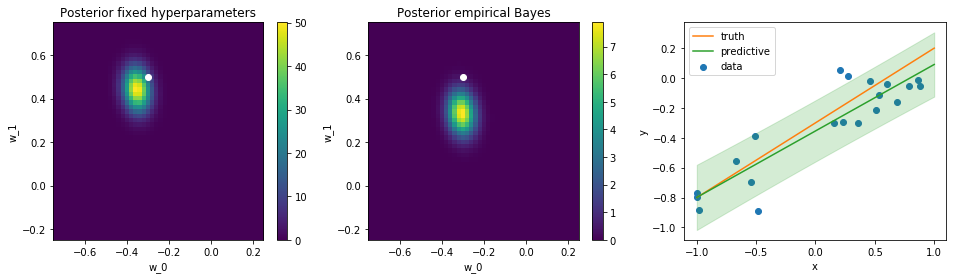

In [6]:
c0, c1, c2 = get_color_cycle(3)

plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plot_gaussian2d(m_N, s_N, extent=[[-0.75, +0.25], [-0.25, +0.75]], bins=(50, 50))
plt.plot([w_true[0]], [w_true[1]], 'wo')
mpl_set(xlabel='w_0', ylabel='w_1', colorbar=True, title='Posterior fixed hyperparameters')

plt.subplot(1, 3, 2)
plot_gaussian2d(m_emp, s_emp, extent=[[-0.75, +0.25], [-0.25, +0.75]], bins=(50, 50))
plt.plot([w_true[0]], [w_true[1]], 'wo')
mpl_set(xlabel='w_0', ylabel='w_1', colorbar=True, title='Posterior empirical Bayes')

plt.subplot(1, 3, 3)
plt.scatter(x_obs[:, 1], y_obs[:, 0], color=c0, label='data')
plt.plot(x_eval[:, 1], x_eval @ w_true, color=c1, label='truth')
plt.plot(x_eval[:, 1], p_m, label='predictive', color=c2)
plt.fill_between(x_eval[:, 1], p_m - p_s ** 0.5, p_m + p_s ** 0.5, color=c2, alpha=0.2)

mpl_set(xlabel='x', ylabel='y', legend=True)
pass

## Bayesian model comparison

Assume mutliple models $\mathcal{M}_i$ under investigation. The posterior for the model is given by

$$
\begin{align}
    \color{red}{p(\mathcal{M}_i|\mathcal{D})} &= 
        \frac{P(\mathcal{M}_i) \color{blue}{p(\mathcal{D}|\mathcal{M}_i)}}{p(\mathcal{D})}
    &\; &\;
\\
    p(t|x, \mathcal{D}) &= \sum_i p(t|x, \mathcal{M}_i, \mathcal{D}) \color{red}{p(\mathcal{M}_i|\mathcal{D})}
    &\; &\;
\\
    \log \color{blue}{p(\mathcal{D}|\mathcal{M}_i)} &= 
        \log \int \mathrm{d}w\; p(\mathcal{D}|w, \mathcal{M}_i) p(w|\mathcal{M}_i) 
    &\; &\;
\\
    &\approx \log  \Delta w_\mathrm{posterior} \log  p(\mathcal{D}|w_\mathrm{MAP}, \mathcal{M}_i)  
    p(w_\mathrm{MAP}|\mathcal{M}_i)
    &\; &\text{strongly peaked posterior}
\\
    &\approx \log  p(\mathcal{D}|w_\mathrm{MAP}, \mathcal{M}_i) +
        \log \frac{\Delta w_\mathrm{posterior} }{\Delta w_\mathrm{prior}}
    &\; &\text{flat prior}
\\
    &\approx \log p(\mathcal{D}|w_\mathrm{MAP}, \mathcal{M}_i) +
        M \log \frac{\Delta w_\mathrm{posterior} }{\Delta w_\mathrm{prior}}
    &\; &\text{for M parameters}
\end{align}
$$

For flat model prior $p(\mathcal{M}_i) = \mathrm{const}$ the relevant quantity is only the model evidence (or marginal likelihood) $\color{blue}{p(\mathcal{D}|\mathcal{M}_i)}$ is relevant.  

Note that, in the approximation above, the model evidence is the sum between a likelihood term (how good the data is fitted) and a complexity term (how many parameters are included). This form favors a model that is complex enough to fit the data, but not too complex.

When approximating the predictive distribution by the most likely model, on selects on average the correct model, as can be seen as follows: Assume the correct model is $\mathcal{M}^\star$, then the average of the log model evidence is equal to

$$
    \mathbb{E}_\mathcal{D} \log p(\mathcal{D}|\mathcal{M}_i) =
    \int \mathrm{d} \mathcal{D}\; p(\mathcal{D}|\mathcal{M}^\star) 
        \log \frac{p(\mathcal{D}|\mathcal{M}^\star)}{p(\mathcal{D}|\mathcal{M}_i)} + \mathrm{const}
$$

I.e., it is equal to the KL divergence to the correct model, which is minimized for the correct model choice.

## The Evidence Approximation

Marginalize over some parameters and choose the maximum likelihood value for the other paramters. Also called Empircal Bayes. For example: marginalize over the weights, but determie the scale parameters by maximizing the marginal likelihood.

$$
    p(\alpha, \beta|\mathcal{D}) \propto p(\mathcal{D}| \alpha, \beta) p(\alpha, \beta)
$$

Assume flat prior and search for $\alpha, \beta$ that maximize the marginal data likelihood

$$
    p(\mathcal{D}| \alpha, \beta) = 
        \int\mathrm{d}w\; p(\mathcal{D}| \mathcal{w}, \beta)p(\mathcal{w}|\alpha)
$$

Note, that both $\alpha$ and $\beta$ are scalar here.

The maximum is given by

$$
\begin{align}
    \gamma &= \sum_i \frac{\lambda_i}{\lambda_i + \alpha} \\
    \alpha &= \frac{\gamma}{m_N^T m_N} \\
    \beta^{-1} &= \frac{1}{N - \gamma} \sum_n \left( t_n - m_N^T \phi_n \right)^2
\end{align}
$$

In principle it would also be possible to first margininalize out the scale parameters and the approximate in the weight variables. However, empirically this leads to poorer results.

## Limitations of Fixed Basis Functions